In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, GRU, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

/Users/ziad/Desktop/Selected DS/proj/myenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = pd.read_csv('dataset.csv')
input_texts = data['English words/sentences'].values
target_texts = data['French words/sentences'].values

# Cut the data to work faster, for now!
input_texts = input_texts[:5000]
target_texts = target_texts[:5000]

In [3]:
input_texts.shape, target_texts.shape

((5000,), (5000,))

In [4]:
eng_tokenizer = Tokenizer(filters='')
eng_tokenizer.fit_on_texts(input_texts)
eng_sequences = eng_tokenizer.texts_to_sequences(input_texts)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_eng_len = max(len(seq) for seq in eng_sequences)

fra_tokenizer = Tokenizer(filters='')
fra_tokenizer.fit_on_texts(target_texts)
fra_sequences = fra_tokenizer.texts_to_sequences(target_texts)
fra_vocab_size = len(fra_tokenizer.word_index) + 1
max_fra_len = max(len(seq) for seq in fra_sequences)

In [5]:
# Pad
eng_sequences = pad_sequences(eng_sequences, maxlen=max_eng_len, padding='post')
fra_sequences = pad_sequences(fra_sequences, maxlen=max_fra_len, padding='post')

# Split
fra_input_sequences = fra_sequences[:, :-1]
fra_output_sequences = fra_sequences[:, 1:]

In [6]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Add, Dense

# Positional Encoding (for both Encoder and Decoder)
def positional_encoding(max_len, d_model):
    angle_rads = np.arange(max_len)[:, np.newaxis] / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)

# Encoder block
def encoder_layer(d_model, num_heads, dff, maximum_position_encoding):
    inputs = Input(shape=(max_eng_len,))

    # Embedding and Positional Encoding
    embedding = Embedding(eng_vocab_size, d_model)(inputs)
    pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    embedding *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embedding += pos_encoding[:max_eng_len, :]

    # Multi-Head Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(embedding, embedding)
    attention = LayerNormalization(epsilon=1e-6)(attention + embedding)

    # Feed Forward Network
    ffn_output = Dense(dff, activation='relu')(attention)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention)

    return Model(inputs, ffn_output)

# Decoder block
def decoder_layer(d_model, num_heads, dff, maximum_position_encoding):
    inputs = Input(shape=(max_fra_len-1,))
    enc_output = Input(shape=(max_eng_len, d_model))

    # Embedding and Positional Encoding
    embedding = Embedding(fra_vocab_size, d_model)(inputs)
    pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    embedding *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embedding += pos_encoding[:max_fra_len-1, :]

    # Multi-Head Attention (Self-attention)
    attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(embedding, embedding)
    attention1 = LayerNormalization(epsilon=1e-6)(attention1 + embedding)

    # Multi-Head Attention (Encoder-Decoder Attention)
    attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(attention1, enc_output)
    attention2 = LayerNormalization(epsilon=1e-6)(attention2 + attention1)

    # Feed Forward Network
    ffn_output = Dense(dff, activation='relu')(attention2)
    ffn_output = Dense(d_model)(ffn_output)
    ffn_output = LayerNormalization(epsilon=1e-6)(ffn_output + attention2)

    return Model([inputs, enc_output], ffn_output)

# Hyperparameters
d_model = 256
num_heads = 8
dff = 512
maximum_position_encoding = max(max_eng_len, max_fra_len)

# Build the encoder and decoder
encoder_inputs = Input(shape=(max_eng_len,))
encoder = encoder_layer(d_model, num_heads, dff, maximum_position_encoding)
encoder_outputs = encoder(encoder_inputs)

decoder_inputs = Input(shape=(max_fra_len-1,))
decoder = decoder_layer(d_model, num_heads, dff, maximum_position_encoding)
decoder_outputs = decoder([decoder_inputs, encoder_outputs])

# Final linear and softmax layer
outputs = Dense(fra_vocab_size, activation='softmax')(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], outputs)
model.compile(optimizer=Adam(learning_rate=0.1), loss='sparse_categorical_crossentropy')


In [7]:
# Print summary of model in extreme detail
model.summary(
    expand_nested=True,
    show_trainable=True,
    line_length=100,
    positions=[.33, .55, .67, 1.]
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)               ┃ Output Shape      ┃  Param # ┃ Connected to               ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)   │ (None, 5)         │        0 │ -                          │    -    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ input_layer_2 (InputLayer) │ (None, 9)         │        0 │ -                          │    -    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ functional (Functional)    │ (None, 5, 256)    │ 2,798,8… │ input_layer[0][0]          │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ input_layer_1         │ (None, 5)         │        0 │ -                          │    -    │
│ (InputLayer)               │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ embedding (Embedding) │ (None, 5, 256)    │  431,360 │ -                          │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ multi_head_attention  │ (None, 5, 256)    │ 2,103,5… │ -                          │    Y    │
│ (MultiHeadAttention)       │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ layer_normalization   │ (None, 5, 256)    │      512 │ -                          │    Y    │
│ (LayerNormalization)       │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ dense (Dense)         │ (None, 5, 512)    │  131,584 │ -                          │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ dense_1 (Dense)       │ (None, 5, 256)    │  131,328 │ -                          │    Y    │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ layer_normalization_1 │ (None, 5, 256)    │      512 │ -                          │    Y    │
│ (LayerNormalization)       │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│ functional_1 (Functional)  │ (None, 9, 256)    │ 5,335,8… │ input_layer_2[0][0],       │    Y    │
│                            │                   │          │ functional[0][0]           │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ input_layer_3         │ (None, 9)         │        0 │ -                          │    -    │
│ (InputLayer)               │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └ embedding_1           │ (None, 9, 256)    │  864,256 │ -                          │    Y    │
│ (Embedding)                │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼────────────────────────────┼─────────┤
│    └                       │ (None, 9, 256)    │ 2,103,5… │ -                          │    Y    │
│ multi_head_attention_1     │                   │          │                            │         │
│ (MultiHeadAttention)       │                   │          │                            │         │
├────────────────────────────┼───────────────────┼──────────┼

 Total params: 9,002,288 (34.34 MB)

 Trainable params: 9,002,288 (34.34 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint('seq2seq_transformer.keras', save_best_only=True)

def scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1))

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

tensorboard = keras.callbacks.TensorBoard(log_dir='logs')

history = model.fit(
    [eng_sequences, fra_input_sequences],
    np.expand_dims(fra_output_sequences, -1),
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler, tensorboard]
)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - loss: 13.7993 - val_loss: 5.8589 - learning_rate: 0.0905
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 86s 5s/step - loss: 4.8597 - val_loss: 5.8364 - learning_rate: 0.0819
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - loss: 3.2099 - val_loss: 3.3698 - learning_rate: 0.0741
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 89s 6s/step - loss: 2.3093 - val_loss: 2.7776 - learning_rate: 0.0670
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 2.0883 - val_loss: 2.6431 - learning_rate: 0.0607
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 91s 6s/step - loss: 2.0433 - val_loss: 2.6621 - learning_rate: 0.0549
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - loss: 2.0355 - val_loss: 2.6471 - learning_rate: 0.0497
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 2.0220 - val_loss: 2.6498 - learning_rate: 0.0449
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - loss: 2.0362 - val_loss: 2.6348 - learning_rate: 0.0407
Epoch 10/20
16/16 ━━━━━━━━

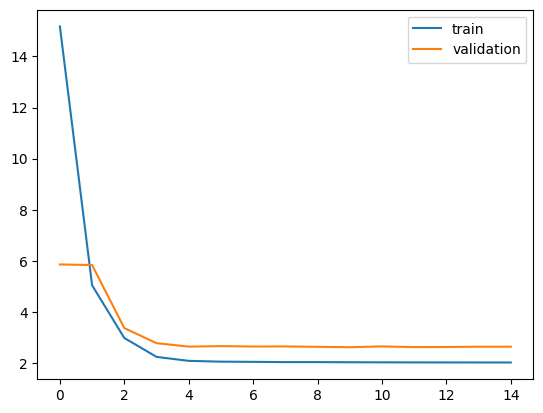

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()